In [1]:
import scanpy 
print('scanpy.__version__:',scanpy.__version__)
import anndata
print('anndata.__version__:',anndata.__version__)


# 导入我们封装好的工具
import scanpy as sc
from remote_conda_decorator import wrap, SmartAnnData
import anndata
import numpy as np

# ==========================================
# 1. 准备数据 (在主环境中)
# ==========================================
adata = sc.read('./data/adata_st.h5ad')

scanpy.__version__: 1.11.2
anndata.__version__: 0.11.4


/opt/conda/envs/scOmni/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


⏳ [Subprocess] Launching 'stlearn' env...
[stlearn] 🎨 [Remote] Graphics redirection enabled.
[stlearn] 🚀 [Remote] Executing function: run_stlearn_kmeans_clustering (Memory Mode)
[stlearn] /opt/conda/envs/stlearn/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
[stlearn] from pkg_resources import get_distribution, DistributionNotFound
[stlearn] --> [Remote Env] Processing AnnData with shape: (324, 15100)
[stlearn] PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
[stlearn] 2025-12-12 12:06:18.639495: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
[stlearn] 2025-12-12 12:06:18.639967: I tensorflow/core/util/port.cc:153] oneDNN custom opera

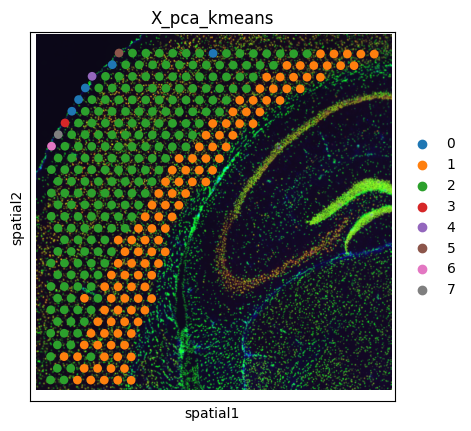

In [2]:
# ==========================================
# 2. 定义远程任务函数
# ==========================================
# 使用 @wrap 装饰器，指定要运行的 conda 环境名称
# 注意：这个函数内部引用的包（如 stlearn）必须在那个 conda 环境里已安装
@wrap("stlearn")
def run_stlearn_kmeans_clustering(adata, n_clusters=7):
    """
    使用 stlearn 对空间转录组数据进行 KMeans 聚类分析。
    参数
    ----
    adata : AnnData 输入的 AnnData 对象，包含空间转录组数据。
    n_clusters : int, 默认=7,KMeans 聚类的簇数。

    返回
    ----
    adata_raw : AnnData
        返回一个复制的 AnnData，其中包含聚类结果保存在 .obs['X_pca_kmeans']。
    """
    import stlearn as st
    import scanpy as sc
    adata_raw = adata.copy()
    print(f"--> [Remote Env] Processing AnnData with shape: {adata.shape}")
    sc.pp.filter_genes(adata, min_cells=3)
    # 模拟 stlearn 的一些预处理
    #st.pp.normalize_total(adata)
    #st.pp.log1p(adata)
    st.em.run_pca(adata, n_comps=50)
    st.pp.neighbors(adata)
    # 聚类
    st.tl.clustering.kmeans(adata, n_clusters=n_clusters, use_data="X_pca", key_added="X_pca_kmeans")
    # 返回处理后的 AnnData
    adata_raw.obs['X_pca_kmeans'] = adata.obs['X_pca_kmeans']
    sc.pl.spatial(adata, color=['X_pca_kmeans'])
    return adata_raw

adata = run_stlearn_kmeans_clustering(adata, n_clusters=8)